In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Load the data

In [102]:
df = pd.read_json('./data/logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Missing values

In [103]:
print(df.isnull().sum())

login_time    0
dtype: int64


##  Check the timezone

In [104]:
# Check if any login_time are timezone-aware
is_timezone_aware = df['login_time'].dt.tz is not None

if is_timezone_aware:
    print("The timestamps are timezone-aware.")
else:
    print("The timestamps are naive (no timezone information).")

The timestamps are naive (no timezone information).


# Part 1 ‐ Exploratory data analysis

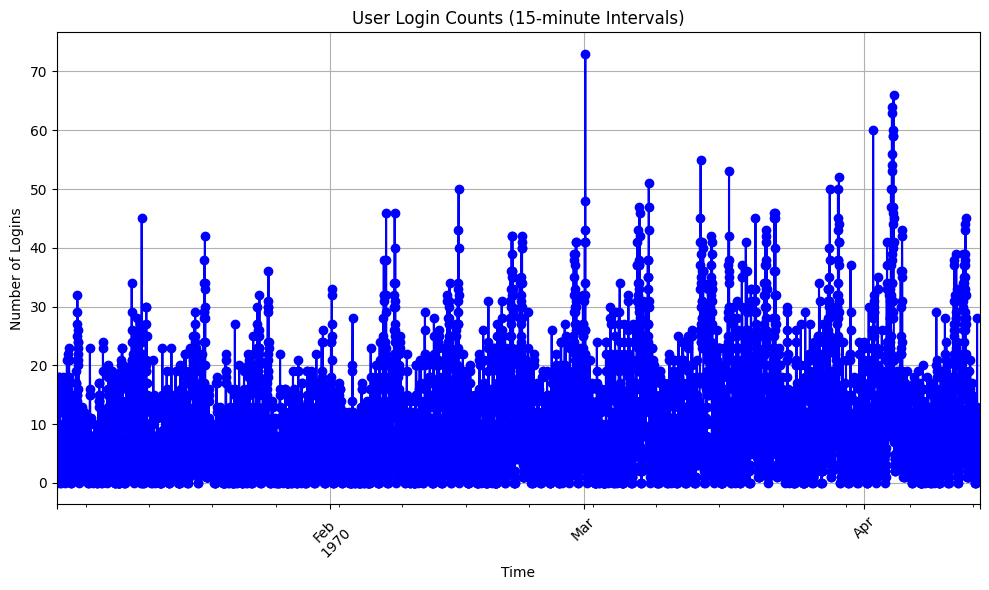

Aggregated login counts:
 login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Freq: 15min, Length: 9788, dtype: int64

Descriptive Statistics:
count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
dtype: float64


In [105]:
# Convert the timestamp to a datetime format
df['login_time'] = pd.to_datetime(df['login_time'])

# Set the timestamp as index
df.set_index('login_time', inplace=True)

# Resample data in 15-minute intervals and count logins
login_counts = df.resample('15min').size()

# Visualize the login counts as a time series
plt.figure(figsize=(10, 6))
login_counts.plot(kind='line', marker='o', linestyle='-', color='b')
plt.title('User Login Counts (15-minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Describe the aggregated time series
print("Aggregated login counts:\n", login_counts)
print("\nDescriptive Statistics:")
print(login_counts.describe())

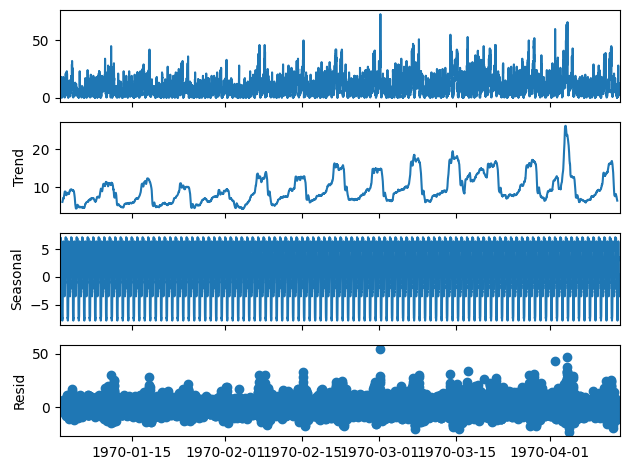

In [106]:
# Decompose the time series
result = seasonal_decompose(login_counts, model='additive', period=96)  # Assuming 24*4=96 intervals per day
result.plot()
plt.show()

There is a slight increasing trend in login activity over time which indicates growth in user engagement.

let's examine how user logins vary throughout the day.

In [107]:
# Resample by hour to count logins per hour
hourly_logins = df.resample('h').size()

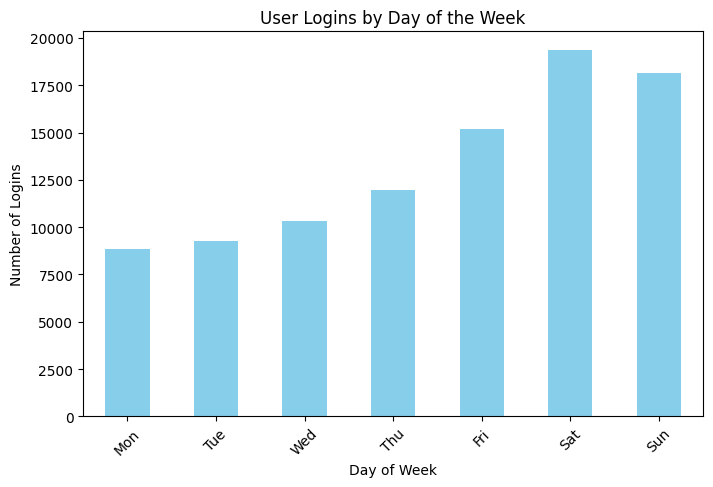

In [108]:
# Group by day of the week (0=Monday, 6=Sunday)
logins_by_weekday = df.groupby(df.index.dayofweek).size()

# Plot the logins per day of the week
plt.figure(figsize=(8, 5))
logins_by_weekday.plot(kind='bar', color='skyblue')
plt.title('User Logins by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Logins')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
plt.show()

Logins are higher during weekends.

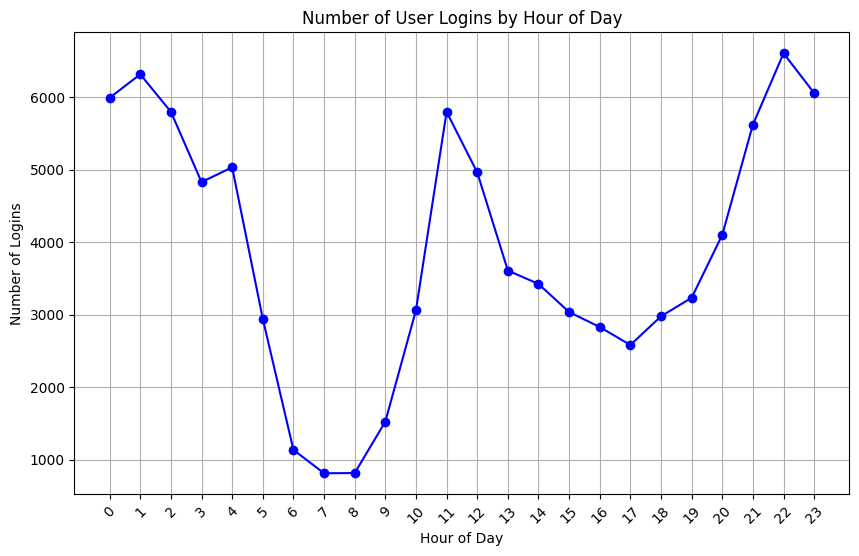

In [109]:
# Resample data to hourly intervals (e.g., each day aggregated)
daily_hourly_logins = df.groupby(df.index.hour).size()

# Plot the hourly login activity
plt.figure(figsize=(10, 6))
daily_hourly_logins.plot(kind='line', color='b', marker='o')
plt.title('Number of User Logins by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Logins')
plt.xticks(range(0, 24), rotation=45)
plt.grid(True)
plt.show()


The number of logins seems to be high late at night, very early in the morning, and around noon. The peaks in the late hours of the night and early hours in the morning suggest that late-night workers, or people who are out late (e.g., people going home from late-night events or work), are logging in late at night to book rides. The peak around 11 AM in the number of user logins could be explained by people logging in to plan or book transportation for lunch breaks or midday activities such as meetings, and appointments.

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

**1.  What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**


In this scenario, the key measure of success for the experiment should be the number of drivers serving both cities over a given period of time or alternatively the percentage of drivers who serve both Gotham and Metropolis on a given day/week/month (i.e., the proportion of drivers crossing the toll bridge to work in both cities). By focusing on drivers willing to serve both cities, the metric directly measures the impact of the toll reimbursement initiative. If the toll costs are reimbursed and the system works as intended, there should be an increase in the number of drivers willing to cross the toll bridge and serve both cities. This helps evaluate whether the reimbursement removes a barrier to driver availability across cities

**2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.** 

***a. how you will implement the experiment***


To compare the effectiveness of the toll reimbursement program, a split test (A/B test) could be used:
- Group A (Control Group: No toll reimbursement): These drivers continue to operate without the encouragement to cross between cities. They will follow their usual routes and schedules, influenced by their existing circadian preferences for serving either Gotham or Metropolis.
We track the number of drivers who serve both cities over a specified period and we can collect data on driver activity and trips made between the cities.
- Group B (Treatment Group: with toll reimbursement): These drivers will receive reimbursement for all toll costs associated with crossing the bridge between Gotham and Metropolis. We can track the number of drivers who serve both cities over a similar period as Group A and we can collect data on the number of times drivers cross the toll bridge and the hours of operation in both cities (to assess any shifts in drivers’ activity patterns).

***b. what statistical test(s) you will conduct to verify the significance of the observation***

We can use a t-test or chi-squared test to verify the significance of the observation by considering these hypothesis:

- Null Hypothesis (H0): There is no significant difference in the percentage of drivers serving both cities between the control group (no toll reimbursement) and the treatment group (with toll reimbursement).
- Alternative Hypothesis (H1): There is a significant increase in the percentage of drivers serving both cities in the treatment group compared to the control group.

***c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.***

- If the experiment shows that the toll reimbursement effectively encourages more drivers to serve both cities and results in improved service (e.g., lower wait times), consider scaling up the program for all drivers.
- Evaluate the total cost of the toll reimbursements against the improvements in service and customer satisfaction. If the cost is justified by the benefits, the program can be expanded.

# Part 3 ‐ Predictive modeling
## Load and explore the data

In [110]:
df_user = pd.read_json('./data/ultimate_data_challenge.json')
df_user.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [111]:
df_user.shape

(50000, 12)

In [112]:
df_user.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

We convert the date columns into datetime type.

In [113]:
df_user['last_trip_date'] = pd.to_datetime(df_user['last_trip_date'])
df_user['signup_date'] = pd.to_datetime(df_user['signup_date'])
df_user['last_trip_date'] = pd.to_datetime(df_user['last_trip_date'])

let's check for missing values

In [114]:
print(df_user.isnull().sum())

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64


As the dataset is pretty large, we propose to drop all rows with null phone values and impute the average rating columns with the median.

In [115]:
df_user['avg_rating_of_driver'] = df_user['avg_rating_of_driver'].fillna(df_user['avg_rating_of_driver'].median())
df_user['avg_rating_by_driver'] = df_user['avg_rating_by_driver'].fillna(df_user['avg_rating_by_driver'].median())
df_user.dropna(subset=['phone'], inplace=True)

In [116]:
print(df_user.isnull().sum())

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64


We propose to analyze user retention with the most recent data point as the reference.

In [117]:

most_recent_date = df_user['last_trip_date'].max()
df_user['retained'] = (most_recent_date - df_user['last_trip_date']).dt.days <= 30
df_user['retained'] = df_user['retained'].astype(int)
df_user.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Plot the distribution of the retained variable (active vs. inactive users).

<Axes: xlabel='retained', ylabel='count'>

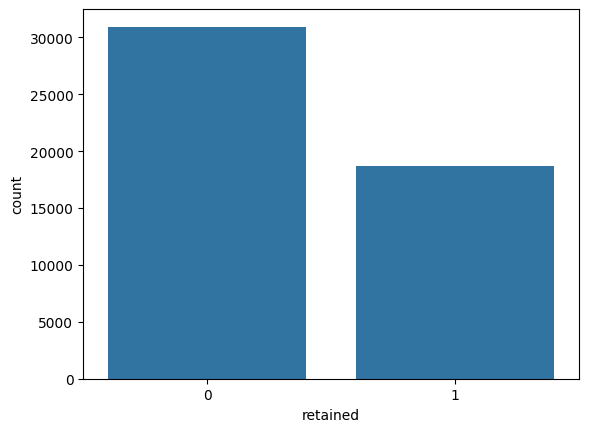

In [118]:
sns.countplot(x='retained', data=df_user)

The dataset is imbalanced

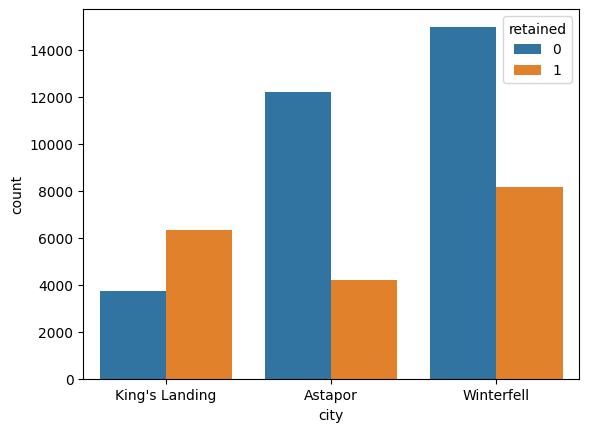

In [119]:
sns.countplot(x="city",data=df_user,hue="retained") 
plt.show()

Users from Winterfell and Astapor have higher retention rates than users from King's Landing.

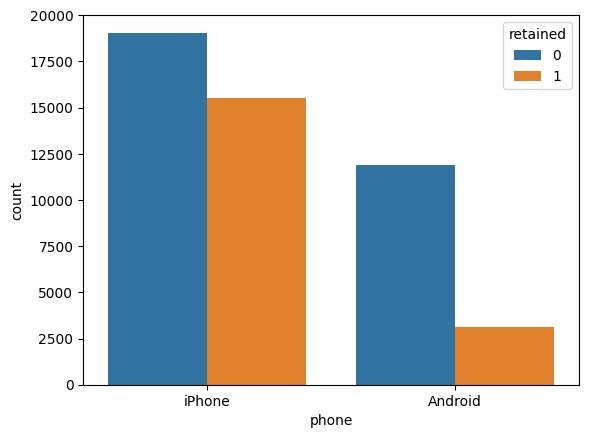

In [120]:
sns.countplot(x="phone",data=df_user,hue="retained") 
plt.show()

Most of users use iPhone and retentions are higher among Android users.

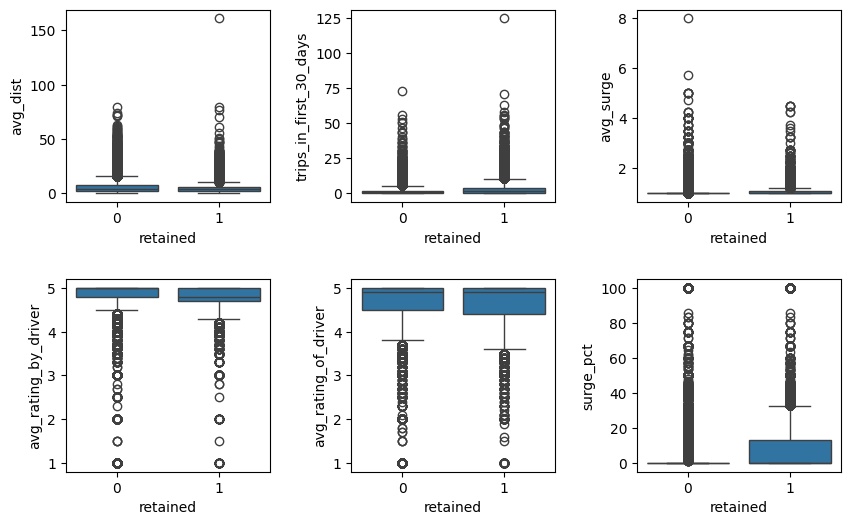

In [121]:
fig,axs = plt.subplots(2,3,figsize=(10,6))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
sns.boxplot(x='retained', y='avg_dist', data=df_user,ax=axs[0,0])
sns.boxplot(x='retained', y='trips_in_first_30_days', data=df_user,ax=axs[0,1])
sns.boxplot(x='retained', y='avg_surge', data=df_user,ax=axs[0,2])
sns.boxplot(x='retained', y='avg_rating_by_driver', data=df_user,ax=axs[1,0])
sns.boxplot(x='retained', y='avg_rating_of_driver', data=df_user,ax=axs[1,1])
sns.boxplot(x='retained', y='surge_pct', data=df_user,ax=axs[1,2])
plt.show()

We propose to remove outliers from trips_in_first_30_days, avg_dist, avg_surge, avg_rating_by_driver, surge_pct, and weekday_pct columns by filtering rows to only include values between the 5th and 95th percentiles.

In [122]:
columns_to_check = ['trips_in_first_30_days', 'avg_dist', 'avg_surge', 'avg_rating_by_driver','avg_rating_of_driver', 'surge_pct']

for column in columns_to_check:
   
    lower_percentile = df_user[column].quantile(0.05) 
    upper_percentile = df_user[column].quantile(0.95)  
    
    df_user = df_user[(df_user[column] >= lower_percentile) & (df_user[column] <= upper_percentile)]

In [123]:
df_user.shape

(36065, 13)

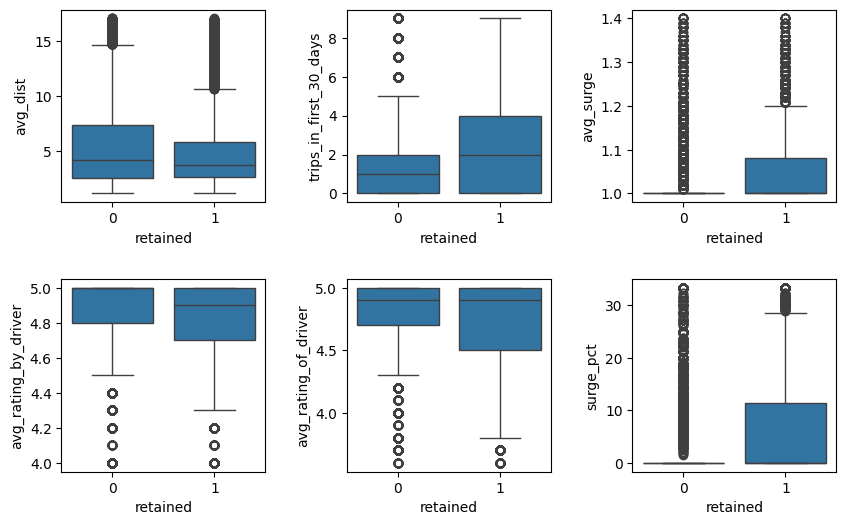

In [124]:
fig,axs = plt.subplots(2,3,figsize=(10,6))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
sns.boxplot(x='retained', y='avg_dist', data=df_user,ax=axs[0,0])
sns.boxplot(x='retained', y='trips_in_first_30_days', data=df_user,ax=axs[0,1])
sns.boxplot(x='retained', y='avg_surge', data=df_user,ax=axs[0,2])
sns.boxplot(x='retained', y='avg_rating_by_driver', data=df_user,ax=axs[1,0])
sns.boxplot(x='retained', y='avg_rating_of_driver', data=df_user,ax=axs[1,1])
sns.boxplot(x='retained', y='surge_pct', data=df_user,ax=axs[1,2])
plt.show()

- Users with higher average distances are more likely to drop off.
- Users who rate drivers poorly or receive low ratings themselves might be more likely to be retained.
- A higher number of trips taken early on indicates retention, as more engaged users are likely to continue using the service.

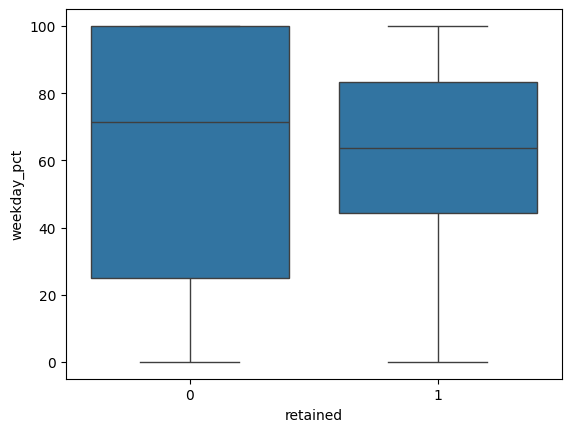

In [125]:
sns.boxplot(x='retained', y='weekday_pct', data=df_user)
plt.show()

Users who take trips more frequently during weekdays have a more consistent travel pattern, which correlate with retention.

Before training our model, we propose to calculate the time between the signup date and last trip date, which could be a strong indicator of user engagement.

In [126]:
df_user['time_since_signup'] = (df_user['last_trip_date'] - df_user['signup_date']).dt.days 
df_user.drop(columns=['signup_date','last_trip_date'],inplace=True)
df_user.head(5)

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,time_since_signup
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1,143
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0,96
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1,170
6,Astapor,1,4.9,1.00,Android,0.0,False,100.0,3.95,4.0,0,1
7,Winterfell,2,5.0,1.00,iPhone,0.0,False,100.0,2.04,5.0,0,1


We next encode categorical varaibles

In [127]:
df_user = pd.get_dummies(df_user, columns=['city', 'phone'], drop_first=True)

In [128]:
df_user.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,time_since_signup,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1,143,True,False,True
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0,96,False,False,False
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1,170,True,False,True
6,1,4.9,1.00,0.0,False,100.0,3.95,4.0,0,1,False,False,False
7,2,5.0,1.00,0.0,False,100.0,2.04,5.0,0,1,False,True,True


## Prediction model
we can now start building predictive models to identify the best factors for predicting retention. 
Possible models include:
- Logistic Regression: A simple baseline model to predict retention (binary outcome: retained vs. not).
- Decision Trees or Random Forest: These models can provide insight into which features are most important in predicting retention.
- Gradient Boosting or XGBoost: These models are more complex and may capture non-linear relationships better, potentially improving prediction accuracy.

As we are interested in analysing features' impact, we propose to train a Random Forest model and an Extreme Gradient Boosting model.

### Split the data

In [129]:
X = df_user.drop(columns=['retained'])
y = df_user['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest model

#### Parameters tuning and training 

In [131]:
param_grid_RF = {
    'n_estimators': [50,100, 200],
    'max_depth': [3, 5, 7,10, 20]
}

grid_search_RF = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_RF, cv=5)
grid_search_RF.fit(X_train, y_train)

print(grid_search_RF.best_params_)


{'max_depth': 10, 'n_estimators': 100}


#### Assess the model performance

In [132]:
y_pred = grid_search_RF.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4381
           1       0.93      0.96      0.95      2832

    accuracy                           0.96      7213
   macro avg       0.95      0.96      0.95      7213
weighted avg       0.96      0.96      0.96      7213

[[4187  194]
 [ 119 2713]]


### XGBoost model
#### Parameters tuning and training 

In [137]:
param_grid_XGB = {
    'learning_rate': np.arange(0.05, 1, 0.05),
    'max_depth': np.arange(2, 10, 1),
    'n_estimators': np.arange(50, 200, 50),
}

grid_search_XGB = GridSearchCV(estimator=GradientBoostingClassifier(random_state=47), param_grid=param_grid_XGB, cv=5)
grid_search_XGB.fit(X_train, y_train)

print(grid_search_XGB.best_params_)

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


#### Assess the model performance

In [138]:
y_pred = grid_search_XGB.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4381
           1       0.94      0.96      0.95      2832

    accuracy                           0.96      7213
   macro avg       0.95      0.96      0.96      7213
weighted avg       0.96      0.96      0.96      7213

[[4195  186]
 [ 113 2719]]


The XGBoost improves slightly the result but trainning is very time consuming. We decide to proceed with Random forest model.

### Feature importance

In [141]:
importances = grid_search_RF.best_estimator_.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importances)


time_since_signup         0.771232
surge_pct                 0.040871
avg_surge                 0.040484
avg_rating_by_driver      0.039582
city_King's Landing       0.029250
weekday_pct               0.021393
phone_iPhone              0.014978
avg_dist                  0.012551
ultimate_black_user       0.010222
avg_rating_of_driver      0.008958
trips_in_first_30_days    0.008397
city_Winterfell           0.002081
dtype: float64


Recommendations:

1. Optimize User Experience During Surge Pricing: consider adjusting pricing models, offering surge-free hours, offering discounts during high-surge times, or providing users with better surge predictions.

2. Provide feedback mechanisms: introduce personalized feedback for users who rate drivers poorly or vice versa, offering tips for improving the experience and encouraging higher satisfaction.

3. Optimize Weekly Travel: For users who mainly travel on weekends, offer weekday-specific promotions or incentives to help users get into a more consistent usage pattern.